# Reeds-Shepp曲线和Dubins曲线

## 什么是Reeds-Shepp曲线？

想象你下班开车回家，到了小区后想把车停到你个人的停车位里面。作为一个喜欢追求挑战的老司机，你想找一条最短的路径把车停进去。那么这样的路径是什么呢？答案就是Reeds-Shepp曲线。Reeds-Shepp曲线由Reeds和Shepp二人在1990年的文章《Optimal paths for a car that goes both forwards and backwards》中提出。


##  Reeds-Shepp曲线是什么样的曲线？

既然是最短路径，我们首先想到的就是直线段，那么它是直线吗？嗯…，在某些情况下，它确实是直线。比如下图左所示的情况，汽车车头刚好对准了停车位（绿色表示停车位，红色表示汽车的起始状态，灰色表示汽车，状态是指汽车的位置和车头的朝向）。可是实际显然不会这么简单，会有各种可能，比如下图右所示的情况：车在停车位的右侧，且车头和停车位平行（侧位停车）。由于汽车都有一个最小转向半径，所以你不能让汽车向螃蟹一样横着开进去，这时求最短路径就没那么简单了。图中汽车中心运动形成的黑色曲线就是Reeds-Shepp曲线。Reeds-Shepp曲线由几段半径固定的圆弧和一段直线段拼接组成，而且圆弧的半径就是汽车的最小转向半径。这里的路径长度是指汽车中心运动轨迹的长度，也就是所有圆弧的弧长和直线段的长度之和。

![](https://images2015.cnblogs.com/blog/1089880/201701/1089880-20170103082231675-1836787887.gif)

![](https://images2015.cnblogs.com/blog/1089880/201701/1089880-20170103082321019-1468429855.gif)

## 数学推导



In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
from enum import Enum


class TurnType(Enum):
    LSL = 1
    LSR = 2
    RSL = 3
    RSR = 4
    RLR = 5
    LRL = 6

class Waypoint:

    def __init__(self, x, y, psi):
        self.x = x
        self.y = y
        self.psi = psi

    def __str__(self):
        return "x: " + str(self.x) + ", y: " + str(self.y) + ", psi: " + str(self.psi)

class Param:
    def __init__(self, p_init, seg_final, turn_radius,):
        self.p_init = p_init
        self.seg_final = seg_final
        self.turn_radius = turn_radius
        self.type = 0

class Trajectory:
    def __init__(self, x, y):
        self.x = x
        self.y = y


def wrapTo360(angle):
    posIn = angle>0
    angle = angle % 360
    if angle == 0 and posIn:
        angle = 360
    return angle

def wrapTo180(angle):
    q = (angle < -180) or (180 < angle)
    if(q):
        angle = wrapTo360(angle + 180) - 180
    return angle

def headingToStandard(hdg):
    # Convert NED heading to standard unit cirlce...degrees only for now (Im lazy)
    thet = wrapTo360(90 - wrapTo180(hdg))
    return thet

def calcDubinsPath(wpt1, wpt2, vel, phi_lim):
    # Calculate a dubins path between two waypoints
    param = Param(wpt1, 0, 0)
    tz        = [0, 0, 0, 0, 0, 0]
    pz        = [0, 0, 0, 0, 0, 0]
    qz        = [0, 0, 0, 0, 0, 0]
    param.seg_final = [0, 0, 0]
    # Convert the headings from NED to standard unit cirlce, and then to radians
    psi1 = headingToStandard(wpt1.psi)*math.pi/180
    psi2 = headingToStandard(wpt2.psi)*math.pi/180

    # Do math
    param.turn_radius = (vel*vel)/(9.8*math.tan(phi_lim*math.pi/180))
    dx = wpt2.x - wpt1.x
    dy = wpt2.y - wpt1.y
    D = math.sqrt(dx*dx + dy*dy)
    d = D/param.turn_radius # Normalize by turn radius...makes length calculation easier down the road.

    # Angles defined in the paper
    theta = math.atan2(dy,dx) % (2*math.pi)
    alpha = (psi1 - theta) % (2*math.pi)
    beta  = (psi2 - theta) % (2*math.pi)
    best_word = -1
    best_cost = -1

    # Calculate all dubin's paths between points
    tz[0], pz[0], qz[0] = dubinsLSL(alpha,beta,d)
    tz[1], pz[1], qz[1] = dubinsLSR(alpha,beta,d)
    tz[2], pz[2], qz[2] = dubinsRSL(alpha,beta,d)
    tz[3], pz[3], qz[3] = dubinsRSR(alpha,beta,d)
    tz[4], pz[4], qz[4] = dubinsRLR(alpha,beta,d)
    tz[5], pz[5], qz[5] = dubinsLRL(alpha,beta,d)

    # Now, pick the one with the lowest cost
    for x in range(6):
        if(tz[x]!=-1):
            cost = tz[x] + pz[x] + qz[x]
            if(cost<best_cost or best_cost==-1):
                best_word = x+1
                best_cost = cost
                param.seg_final = [tz[x],pz[x],qz[x]]

    param.type = TurnType(best_word)
    return param

# Here's all of the dubins path math
def dubinsLSL(alpha, beta, d):
    tmp0      = d + math.sin(alpha) - math.sin(beta)
    tmp1      = math.atan2((math.cos(beta)-math.cos(alpha)),tmp0)
    p_squared = 2 + d*d - (2*math.cos(alpha-beta)) + (2*d*(math.sin(alpha)-math.sin(beta)))
    if p_squared<0:
        print('No LSL Path')
        p=-1
        q=-1
        t=-1
    else:
        t         = (tmp1-alpha) % (2*math.pi)
        p         = math.sqrt(p_squared)
        q         = (beta - tmp1) % (2*math.pi)
    return t, p, q

def dubinsRSR(alpha, beta, d):
    tmp0      = d - math.sin(alpha) + math.sin(beta)
    tmp1      = math.atan2((math.cos(alpha)-math.cos(beta)),tmp0)
    p_squared = 2 + d*d - (2*math.cos(alpha-beta)) + 2*d*(math.sin(beta)-math.sin(alpha))
    if p_squared<0:
        print('No RSR Path')
        p=-1
        q=-1
        t=-1
    else:
        t         = (alpha - tmp1 ) % (2*math.pi)
        p         = math.sqrt(p_squared)
        q         = (-1*beta + tmp1) % (2*math.pi)
    return t, p, q

def dubinsRSL(alpha,beta,d):
    tmp0      = d - math.sin(alpha) - math.sin(beta)
    p_squared = -2 + d*d + 2*math.cos(alpha-beta) - 2*d*(math.sin(alpha) + math.sin(beta))
    if p_squared<0:
        print('No RSL Path')
        p=-1
        q=-1
        t=-1
    else:
        p         = math.sqrt(p_squared)
        tmp2      = math.atan2((math.cos(alpha)+math.cos(beta)),tmp0) - math.atan2(2,p)
        t         = (alpha - tmp2) % (2*math.pi)
        q         = (beta - tmp2) % (2*math.pi)
    return t, p, q

def dubinsLSR(alpha, beta, d):
    tmp0      = d + math.sin(alpha) + math.sin(beta)
    p_squared = -2 + d*d + 2*math.cos(alpha-beta) + 2*d*(math.sin(alpha) + math.sin(beta))
    if p_squared<0:
        print('No LSR Path')
        p=-1
        q=-1
        t=-1
    else:
        p         = math.sqrt(p_squared)
        tmp2      = math.atan2((-1*math.cos(alpha)-math.cos(beta)),tmp0) - math.atan2(-2,p)
        t         = (tmp2 - alpha) % (2*math.pi)
        q         = (tmp2 - beta) % (2*math.pi)
    return t, p, q

def dubinsRLR(alpha, beta, d):
    tmp_rlr = (6 - d*d + 2*math.cos(alpha-beta) + 2*d*(math.sin(alpha)-math.sin(beta)))/8
    if(abs(tmp_rlr)>1):
        print('No RLR Path')
        p=-1
        q=-1
        t=-1
    else:
        p = (2*math.pi - math.acos(tmp_rlr)) % (2*math.pi)
        t = (alpha - math.atan2((math.cos(alpha)-math.cos(beta)), d-math.sin(alpha)+math.sin(beta)) + p/2 % (2*math.pi)) % (2*math.pi)
        q = (alpha - beta - t + (p % (2*math.pi))) % (2*math.pi)

    return t, p, q

def dubinsLRL(alpha, beta, d):
    tmp_lrl = (6 - d*d + 2*math.cos(alpha-beta) + 2*d*(-1*math.sin(alpha)+math.sin(beta)))/8
    if(abs(tmp_lrl)>1):
        print('No LRL Path')
        p=-1
        q=-1
        t=-1
    else:
        p = (2*math.pi - math.acos(tmp_lrl)) % (2*math.pi)
        t = (-1*alpha - math.atan2((math.cos(alpha)-math.cos(beta)), d+math.sin(alpha)-math.sin(beta)) + p/2) % (2*math.pi)
        q = ((beta % (2*math.pi))-alpha-t+(p % (2*math.pi))) % (2*math.pi)
        print(t,p,q,beta,alpha)
    return t, p, q

def dubins_traj(param,step):
    # Build the trajectory from the lowest-cost path
    x = 0
    i = 0
    length = (param.seg_final[0]+param.seg_final[1]+param.seg_final[2])*param.turn_radius
    length = math.floor(length/step)
    path = -1 * np.ones((length,3))

    while x < length:
        path[i] = dubins_path(param,x)
        x += step
        i+=1
    return path


def dubins_path(param, t):
    # Helper function for curve generation
    tprime = t/param.turn_radius
    p_init = np.array([0,0,headingToStandard(param.p_init.psi)*math.pi/180])
    #
    L_SEG = 1
    S_SEG = 2
    R_SEG = 3
    DIRDATA = np.array([[L_SEG,S_SEG,L_SEG],[L_SEG,S_SEG,R_SEG],[R_SEG,S_SEG,L_SEG],[R_SEG,S_SEG,R_SEG],[R_SEG,L_SEG,R_SEG],[L_SEG,R_SEG,L_SEG]])
    #
    types = DIRDATA[param.type.value-1][:]
    param1 = param.seg_final[0]
    param2 = param.seg_final[1]
    mid_pt1 = dubins_segment(param1,p_init,types[0])
    mid_pt2 = dubins_segment(param2,mid_pt1,types[1])

    if(tprime<param1):
        end_pt = dubins_segment(tprime,p_init,types[0])
    elif(tprime<(param1+param2)):
        end_pt = dubins_segment(tprime-param1,mid_pt1,types[1])
    else:
        end_pt = dubins_segment(tprime-param1-param2, mid_pt2, types[2])

    end_pt[0] = end_pt[0] * param.turn_radius + param.p_init.x
    end_pt[1] = end_pt[1] * param.turn_radius + param.p_init.y
    end_pt[2] = end_pt[2] % (2*math.pi)

    return end_pt

def dubins_segment(seg_param, seg_init, seg_type):
    # Helper function for curve generation
    L_SEG = 1
    S_SEG = 2
    R_SEG = 3
    seg_end = np.array([0.0,0.0,0.0])
    if( seg_type == L_SEG ):
        seg_end[0] = seg_init[0] + math.sin(seg_init[2]+seg_param) - math.sin(seg_init[2])
        seg_end[1] = seg_init[1] - math.cos(seg_init[2]+seg_param) + math.cos(seg_init[2])
        seg_end[2] = seg_init[2] + seg_param
    elif( seg_type == R_SEG ):
        seg_end[0] = seg_init[0] - math.sin(seg_init[2]-seg_param) + math.sin(seg_init[2])
        seg_end[1] = seg_init[1] + math.cos(seg_init[2]-seg_param) - math.cos(seg_init[2])
        seg_end[2] = seg_init[2] - seg_param
    elif( seg_type == S_SEG ):
        seg_end[0] = seg_init[0] + math.cos(seg_init[2]) * seg_param
        seg_end[1] = seg_init[1] + math.sin(seg_init[2]) * seg_param
        seg_end[2] = seg_init[2]

    return seg_end

No RLR Path
No LRL Path


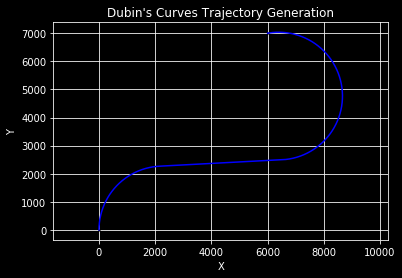

In [4]:
pt1 = Waypoint(0,0,0)
pt2 = Waypoint(6000,7000,260)
#pt3 = Waypoint(1000,15000,180)
#pt4 = Waypoint(0,0,270)
Wptz = [pt1, pt2]
# Run the code
i = 0
while i<len(Wptz)-1:
    param = calcDubinsPath(Wptz[i], Wptz[i+1], 90, 20)
    path = dubins_traj(param,1)

    # Plot the results
    plt.plot(Wptz[i].x,Wptz[i].y,'kx')
    plt.plot(Wptz[i+1].x,Wptz[i+1].y,'kx')
    plt.plot(path[:,0],path[:,1],'b-')
    i+=1
plt.grid(True)
plt.axis("equal")
plt.title('Dubin\'s Curves Trajectory Generation')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()